In [1]:
import pandas as pd
import numpy as np

In [9]:
data = pd.read_csv("eq_1960_2022.csv")

In [3]:
data.head()

,time,latitude,longitude,depth,mag
0,2021-12-01,35.2280,141.4204,10.00,4.7
1,2021-12-01,35.2774,141.5336,10.00,4.7
2,2021-12-01,33.7690,137.1036,362.75,4.0
3,2021-12-01,35.2014,141.4165,10.00,4.5
4,2021-12-01,35.1430,141.3281,10.00,4.9


## Data Preprocessing

### Division en zones

On récupère le code précèdent

In [11]:
from collections import namedtuple

Coords = namedtuple("Coords", "lat_min lat_max lon_min lon_max")

In [12]:
zones = {"A": Coords(41, 46, 140, 146), "B": Coords(37, 41, 138, 142), "C": Coords(34, 37, 137, 141), "D": Coords(33, 37, 133, 137), "E": Coords(31, 36, 129, 133), "F": Coords(38, 41, 142, 144), "G": Coords(36, 38, 141, 143)}

def to_5_zone(lat: float, lon: float):
    """Convert coordinates to a zone number according to the map arrangement above"""
    for zone, coord in zones.items():
        if (coord.lat_min <= lat <= coord.lat_max) & (coord.lon_min <= lon <= coord.lon_max):
            return zone
    return 0


In [13]:
data["zone"] = data.apply(lambda x: to_5_zone(x['latitude'], x['longitude']), axis=1)

Pour simplifier, nous utiliserons 5 zones découpées ainsi : trois zones en zone verte et 2 en zone bleues (cf code d'Ibrahima).  
Ces zones sont celles qui nous intéressent le plus car directement situé sur l'île. Cependant, nous utiliserons également 2 zones supplémentaires dans l'océan pacifique où se trouve le plus grand nombre d'EQ.  
  
![carte_japon.jpg](carte_japon.jpg)

zone A : île nord (Hokkaido) 41°N à 46°N et 140°E à 146°E  
zone B : Tohoku district, 37°N à 41°N et 138°E à 142°E  
zone C : Kanto et Chubu districts, 34°N à 37°N et 137°E à 141°E  
zone D : Kinki, Chugoku et Shikoku districts, 33°N à 37°N et 133°E à 137°E  
zone E : Kyushu district, 31°N à 36°N et 129°E à 133°E  
zone F : 38°N à 41°N et 142°E à 144°E  
zone G : 36°N à 38°N et 141°E à 143°E

In [7]:
data.head()

,time,latitude,longitude,depth,mag,zone
0,2021-12-01,35.2280,141.4204,10.00,4.7,0
1,2021-12-01,35.2774,141.5336,10.00,4.7,0
2,2021-12-01,33.7690,137.1036,362.75,4.0,0
3,2021-12-01,35.2014,141.4165,10.00,4.5,0
4,2021-12-01,35.1430,141.3281,10.00,4.9,0


In [8]:
data.zone.value_counts()

0    14129
C     4334
A     3928
F     3589
B     3170
G     3039
E      989
D      890
Name: zone, dtype: int64

In [14]:
data[data.mag >= 4.5].zone.value_counts()

0    7659
F    2284
C    2071
A    2018
B    1721
G    1675
E     528
D     302
Name: zone, dtype: int64

On va s'intéresser uniquement au sinistre de mag >= 4.5 dans les zones précèdentes afin de faire de la prédiction en fréquence

In [15]:
df = data[(data.mag >= 4.5) & (data.zone != 0)]

In [16]:
df["time"] = pd.to_datetime(df.time)

C:\Users\asus\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [79]:
df

,time,latitude,longitude,depth,mag,zone
13,2021-12-01,36.1875,140.0911,51.68,5.0,C
20,2021-12-02,37.7216,141.7845,57.22,4.8,B
23,2021-12-02,35.5460,139.0340,26.64,4.5,C
24,2021-12-02,45.8325,142.5511,314.40,4.6,A
26,2021-12-03,33.8337,135.0775,12.08,5.2,D
...,...,...,...,...,...,...
34063,1960-03-23,39.1370,143.5980,25.00,5.9,F
34064,1960-03-23,39.1460,143.5640,25.00,5.8,F
34065,1960-03-23,39.2350,143.3030,15.00,6.2,F
34066,1960-02-04,38.6670,143.0140,25.00,6.1,F


On récupère le nombre d'EQ par mois

In [17]:
zone_to_col = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6}

def to_full_dataset():
    T = (2022 - 1960) * 12  # nb de mois total
    M = 7  # nb de zones
    X_full = np.zeros((T, M), dtype=np.uint8)  # matrice contenant le nb d'EQ avec en ligne les mois par ordre chronologique et en colonne les zones
    for tup in df.itertuples():
        irow = (tup.time.year - 1960)* 12 + tup.time.month - 1
        icol = zone_to_col[tup.zone]
        X_full[irow, icol] += 1
    
    return X_full

In [18]:
X_full = to_full_dataset()

In [14]:
X_full.shape

(744, 7)

In [22]:
from itertools import product

monthly_ix = pd.to_datetime([f"{y}-{m}" for y, m in product(list(range(1960, 2022)), list(range(1, 13)))])

In [23]:
X_full_pd = pd.DataFrame(X_full, index = monthly_ix, columns=["A", "B", "C", "D", "E", "F", "G"])

In [24]:
X_full_pd

,A,B,C,D,E,F,G
1960-01-01,0,0,0,1,0,0,0
1960-02-01,0,0,0,0,0,1,0
1960-03-01,0,0,0,0,0,10,0
1960-04-01,0,0,0,0,0,0,0
1960-05-01,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2021-08-01,1,2,1,1,0,0,32
2021-09-01,2,6,2,0,2,3,1
2021-10-01,6,1,3,1,1,5,2
2021-11-01,2,3,4,0,2,1,3


In [25]:
X_full_pd.to_csv("monthly_count_1960_2022.csv")

# Model

In [1]:
import pandas as pd
import numpy as np

In [53]:
df = pd.read_csv("monthly_count_1960_2022.csv")

In [54]:
df.rename({"Unnamed: 0": "date"}, axis=1, inplace=True)

In [55]:
df.date = pd.to_datetime(df.date)

In [56]:
df = df.set_index("date")

In [57]:
df.head()

,A,B,C,D,E,F,G
date,,,,,,,
1960-01-01,0,0,0,1,0,0,0
1960-02-01,0,0,0,0,0,1,0
1960-03-01,0,0,0,0,0,10,0
1960-04-01,0,0,0,0,0,0,0
1960-05-01,0,0,0,0,0,0,0


In [24]:
df.loc['1980']

,A,B,C,D,E,F,G
date,,,,,,,
1980-01-01,6,1,0,0,0,0,2
1980-02-01,4,2,2,0,7,1,1
1980-03-01,0,2,2,1,0,1,0
1980-04-01,5,0,0,0,0,2,0
1980-05-01,1,0,1,0,0,1,4
1980-06-01,1,2,8,0,1,1,0
1980-07-01,3,3,0,0,0,1,0
1980-08-01,2,0,1,1,0,1,1
1980-09-01,2,1,6,1,0,1,0


NameError: name 'ax' is not defined

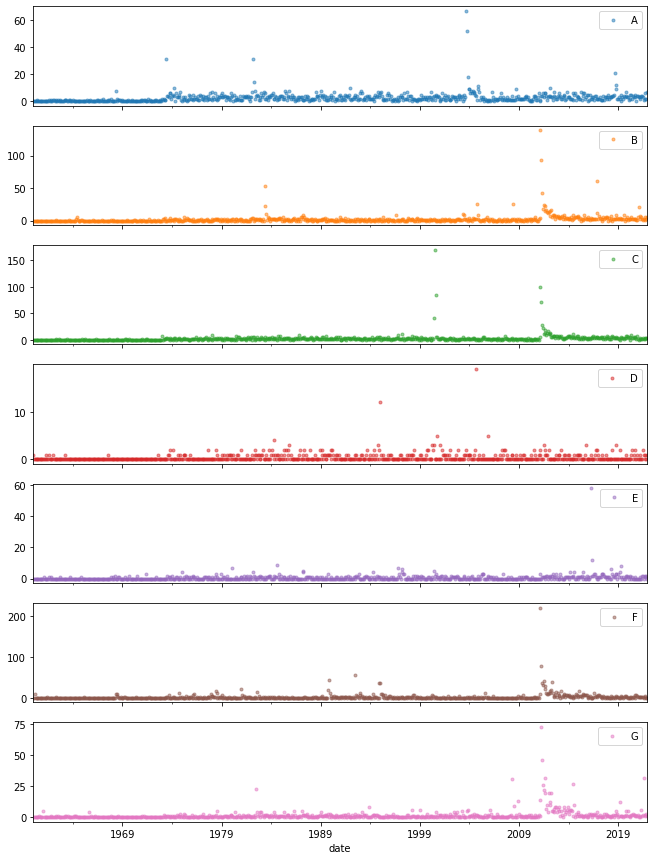

In [7]:
import matplotlib.pyplot as plt

cols_plot = ["A", "B", "C", "D", "E", "F", "G"]
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 15), subplots=True)
ax.set_ylabel('Number of EQ with $M_c \geq 4.5$')

On sépare les données en train set et test set en prenant les données de 1960 à 2014 pour le train set et le reste pour le test set

In [19]:
X_train = X_full[:55*12]
X_train.shape

(660, 7)

In [20]:
X_test = X_full[55*12:]
X_test.shape

(84, 7)

On va séparer les inputs des outputs. On va utiliser une lookback window de $\tau = 60 \text{ mois}$. On ne prend pas de padding, ce qui veut dire que les inputs commencent à $ t = \tau+ 1 $

In [21]:
def split_input(dataset: np.array, tau: int, padding=False):
    """Convert dataset to input output arrays for time series prediction
    params: dataset: the dataset to perform the split with. Time component in dimension 0
            tau: lookback window ( tau < len(dataset) )
    returns: X, y: input and output array of shape (n - tau - 1, tau, n_features) and (n - tau - 1, n_features)"""
    X, Y = [], []
    n = len(dataset)
    assert tau < n, "tau > len(dataset)"
    assert tau > 0, "padding < 1"

    # without padding
    for i in range(n - tau - 1):
        X.append(dataset[i:i + tau])
        Y.append(dataset[i + tau + 1])
    
    return np.array(X), np.array(Y)


In [22]:
tau = 84  # 7 ans

In [23]:
X, y = split_input(X_train, tau)

On obtient bien les dimensions souhaitées : (n_sample, timesteps, n_features)

In [24]:
X.shape

(575, 84, 7)

In [29]:
y.shape

(575, 7)

Pour résumer, $X$ contient donc des matrices de taille (60, 7) avec 60 la taille de la lookback window et 7 le nombre de features (ici les zones).  
On essaiera plus tard d'avoir un nombre de feature en 2D comme first model

## Naïve Model

Avec nos données à disposition, nous faisons face à un problème de multi output regression. De plus les valeurs à prédire doivent êtrepositive et entières, ce qui nous oriente vers une fonction d'activation relu. On utilisera la fonction d'arrondi pour avoir un nombre entier.

In [30]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow import keras
import tensorflow as tf

n_features = X.shape[2]
n_timesteps = X.shape[1]

model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(n_features, activation='relu'))
model.compile(optimizer='adam', loss='mse')

In [26]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [31]:
tf.config.run_functions_eagerly(True)

In [32]:
history = model.fit(X, y, epochs=400, verbose=1, callbacks=[callback])

Epoch 1/400


C:\Users\asus\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


18/18 [==============================] - 13s 598ms/step - loss: 48.5281
Epoch 2/400
18/18 [==============================] - 10s 560ms/step - loss: 46.7678
Epoch 3/400
18/18 [==============================] - 10s 529ms/step - loss: 46.2674
Epoch 4/400
18/18 [==============================] - 10s 534ms/step - loss: 45.6205
Epoch 5/400
18/18 [==============================] - 10s 536ms/step - loss: 45.0384
Epoch 6/400
18/18 [==============================] - 9s 524ms/step - loss: 44.3700
Epoch 7/400
18/18 [==============================] - 10s 530ms/step - loss: 44.1965
Epoch 8/400
18/18 [==============================] - 10s 533ms/step - loss: 43.1153
Epoch 9/400
18/18 [==============================] - 10s 531ms/step - loss: 42.0653
Epoch 10/400
18/18 [==============================] - 10s 546ms/step - loss: 41.6893
Epoch 11/400
18/18 [==============================] - 10s 544ms/step - loss: 40.9199
Epoch 12/400
18/18 [==============================] - 10s 537ms/step - loss: 40.3931
Ep

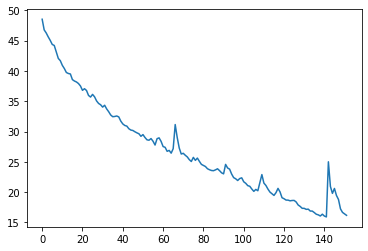

In [33]:
plt.plot(history.history['loss'])

In [40]:
np.round(model.predict(X))

C:\Users\asus\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 6., 7., ..., 1., 5., 4.],
       [4., 7., 8., ..., 2., 6., 6.],
       [4., 5., 5., ..., 1., 3., 5.]], dtype=float32)

In [47]:
from itertools import product

monthly_ix = pd.to_datetime([f"{y}-{m}" for y, m in product(list(range(1967, 2014)), list(range(1, 13)))] + 
[f"2014-{m}" for m in range(1, 12)])

In [99]:
train_pred = pd.DataFrame(np.round(model.predict(X)), index=monthly_ix, columns=['A train', 'B train', 'C train', 'D train', 'E train', 'F_train', 'G train'], dtype=np.uint8)

C:\Users\asus\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



<AxesSubplot:xlabel='date'>

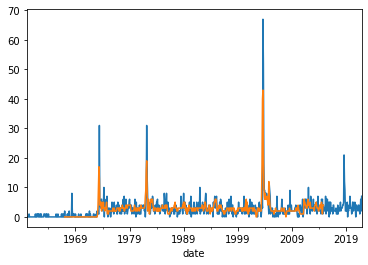

In [62]:
df["A"].plot()  # ground truth
train_pred["A"].plot()  # trained 

On va maintenant prédire les résultats sur le test set. Il faut d'abord réarranger l'input du test set. En effet, le test set commence à $X_{660}$, on récupère donc les valeurs de $ t = 660 - \tau - 1 $ à $ t = 744 - \tau - 1 $. 

In [63]:
X_test.shape

(84, 7)

In [78]:
X_test_input,_  = split_input(X_full[660 - tau - 1 :], tau)

In [79]:
X_test_input.shape

(84, 84, 7)

In [80]:
y_pred = model.predict(X_test_input)

C:\Users\asus\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\data\ops\structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [81]:
y_pred

array([[4.2508998e+00, 5.0075755e+00, 5.6644297e+00, 2.8066638e-01,
        1.0969833e+00, 3.8773043e+00, 5.5312681e+00],
       [5.2134676e+00, 4.3105626e+00, 5.6388321e+00, 1.0587296e-01,
        1.5233428e+00, 4.0318356e+00, 5.5871544e+00],
       [5.3216295e+00, 3.4364982e+00, 4.5805354e+00, 4.9144402e-02,
        1.5406400e+00, 2.9072354e+00, 5.3606143e+00],
       [4.1177363e+00, 2.4700003e+00, 3.6266286e+00, 2.8423470e-01,
        7.4812949e-01, 1.5318782e+00, 4.4468927e+00],
       [3.4778609e+00, 3.1843045e+00, 5.1072154e+00, 1.7125985e-01,
        8.5996288e-01, 2.9324405e+00, 4.4840269e+00],
       [3.2530255e+00, 2.4320080e+00, 4.4424453e+00, 2.5676689e-01,
        7.1780801e-01, 2.4368262e+00, 3.8826389e+00],
       [3.0506425e+00, 2.6031530e+00, 4.9178023e+00, 1.3814560e-01,
        8.6676127e-01, 2.7165177e+00, 3.5073762e+00],
       [3.1192408e+00, 2.0978487e+00, 3.8072844e+00, 2.2769219e-01,
        5.5966610e-01, 2.2404273e+00, 3.4842756e+00],
       [2.7300367e+00, 2

In [89]:
monthly_ix_test = pd.to_datetime([f"{y}-{m}" for y, m in product(list(range(2015, 2022)), list(range(1, 13)))])

test_pred = pd.DataFrame(np.round(y_pred), index=monthly_ix_test, columns=['A pred', 'B pred', 'C pred', 'D pred', 'E pred', 'F pred', 'G pred'], dtype=np.uint8)

In [90]:
test_pred

,A pred,B pred,C pred,D pred,E pred,F pred,G pred
2015-01-01,4,5,6,0,1,4,6
2015-02-01,5,4,6,0,2,4,6
2015-03-01,5,3,5,0,2,3,5
2015-04-01,4,2,4,0,1,2,4
2015-05-01,3,3,5,0,1,3,4
...,...,...,...,...,...,...,...
2021-08-01,10,0,7,1,1,0,2
2021-09-01,10,0,8,1,1,1,2
2021-10-01,6,0,1,1,1,0,0
2021-11-01,4,1,3,1,1,0,0


<AxesSubplot:xlabel='date'>

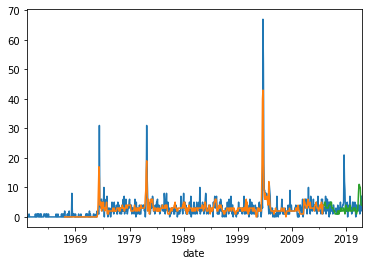

In [85]:
df["A"].plot()  # ground truth
train_pred["A"].plot()  # trained 
test_pred["A"].plot()   # prediction

In [100]:
res = pd.concat([df, train_pred, test_pred], axis=1)

In [92]:
res.head()

,A,B,C,D,E,F,G,A train,B train,C train,...,E train,F_train,G train,A pred,B pred,C pred,D pred,E pred,F pred,G pred
1960-01-01,0,0,0,1,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02-01,0,0,0,0,0,1,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-03-01,0,0,0,0,0,10,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-04-01,0,0,0,0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-05-01,0,0,0,0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
import plotly.express as px

fig = px.line(res[["A", "A train", "A pred"]])
fig.show()

In [101]:
fig = px.line(res[["B", "B train", "B pred"]])
fig.show()

In [98]:
fig = px.line(res[["C", "C train", "C pred"]])
fig.show()

In [102]:
fig = px.line(res[["D", "D train", "D pred"]])
fig.show()

In [103]:
fig = px.line(res[["E", "E train", "E pred"]])
fig.show()

Les résultats pour la zone A sont assez satisfaisant, sachant que l'on souhaite prédire sur une période d'au moins 4 ans. Pour le reste, les données sont compliquées à exploiter...  
Sauvegardons le modèle et essayons autre chose.

In [104]:
model.save("model2_freq_LSTM")

INFO:tensorflow:Assets written to: model2_freq_LSTM\assets


INFO:tensorflow:Assets written to: model2_freq_LSTM\assets


In [105]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 84, 100)           43200     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 7)                 707       
                                                                 
Total params: 124,307
Trainable params: 124,307
Non-trainable params: 0
_________________________________________________________________
